
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analyzing Spot Diffraction Pattern

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_08-Spot_Diffraction_Pattern.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main//Diffraction/CH2_08-Spot_Diffraction_Pattern.ipynb)
 
part of

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade

if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
print('done')

installing pyTEMlib
done


## Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [1]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

# additional package 
import  itertools 
import scipy.constants as const
import ipywidgets as ipyw

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic scattering Library
                             # Atomic form factors from Kirkland's book

### And we use the image tool library of pyTEMlib
import pyTEMlib.file_tools as ft
print(pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
0.2024.09.0


## Acquisition of Selected Area Diffraction Patterns

Practical steps:
- Make sure that area of interest is in focus.
- Insert SAD or equivalent aperture in image plane
- Remove objective aperture (let all the diffracted beams through)
- Focus the SAD aperture (Put's that aperture  in the image plane of the objective lens)
- Switch to diffraction mode 
- Adjust convergence angle  (C3) within the limits given by the area you want to investigate
- Focus the diffraction pattern with the intermediate lens (diffraction focus).
- Correct astigmatism 
- Block zero beam with the pointer. (You can damage the CCD)
- Use long exposer times ($>$ 1 sec: better dynamics, sharper pattern) or even take several at different exposure times. 

>**Some tips:**
>- cooling the specimen will reduce thermal diffuse scattering (scattering at phonons).
>
>- With a Gatan Image Filter (GIF) or an in-column filter one can filter out the inelastic scattering  (lower energy) electrons responsible for a lot of the background intensity.
>
>- CCD cameras usually have a lower dynamic range  and can be easily damaged by the zero refection. Summing several diffraction-pattern increases the dynamic range of the data.
>
>- Changes in the lattice parameter due to stress will not be easily seen in the diffraction patterns, but HOLZ line patterns (later) give that level of accuracy.


## Load Spot-Diffraction Pattern

First we select the diffraction pattern

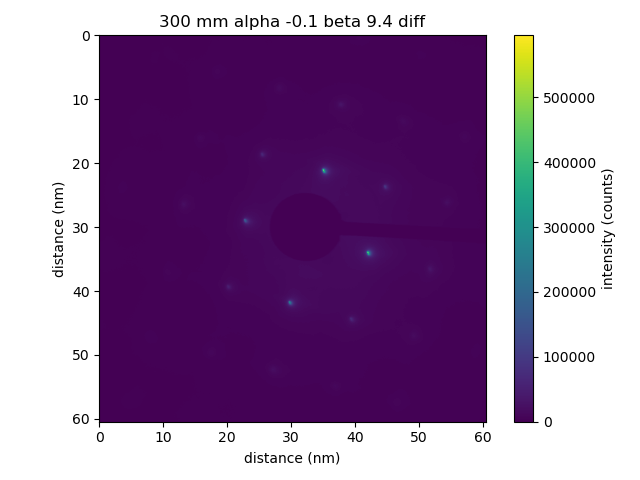

In [2]:
file_name = '..\\example_data\\Si001_300mm_alpha0.1_beta9.4_diff.dm3'
sidpy_datasets = ft.open_file(file_name)
sidpy_dataset = sidpy_datasets['Channel_000']
view = sidpy_dataset.plot()

### Plotting on a logarithmic scale

The dynamic range in diffraction data is even larger than in images and so for a good presentation of the data it is advantageous to go to plot the intensities in a logarithmic scale.

To present data in logarithmic scale no negative values (noise) can be in these data and so all negative values in the dataset will be set to zero.

The factor 1 in front of the diffraction pattern in the log numpy function in the ``imshow`` is the gamma value.
Changing that value will change the contrast.

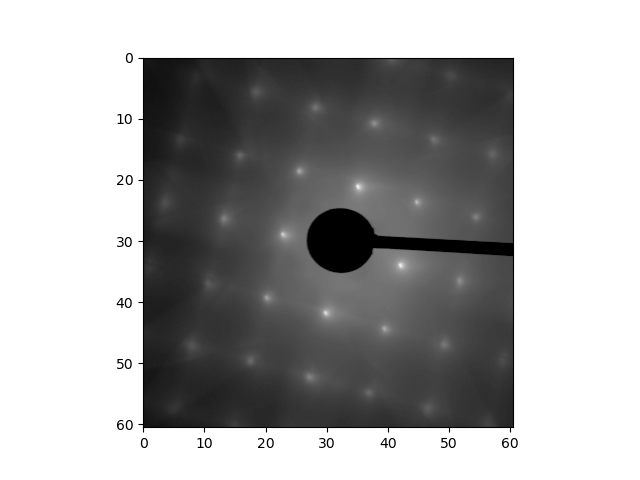

In [3]:
diff_pattern = np.array(sidpy_dataset).T
diff_pattern[diff_pattern<0] = 0.
extent = sidpy_dataset.get_extent([0,1])
fig = plt.figure() 
plt.imshow(np.log(1+diff_pattern),cmap="gray", vmin=np.max(np.log(1+diff_pattern))*0.5, extent=extent);
scale_300mm = 0.012829394079744816

## Finding the center

First try with cross correlation of rotated images


### Finding the center of the beam-stop

The beam-stop is naturally dark, and we first select the dark regions.
These dark regions are naturally spotty, and we set all small values to

We first find the maximum of the profile for the 


1101 1016.5


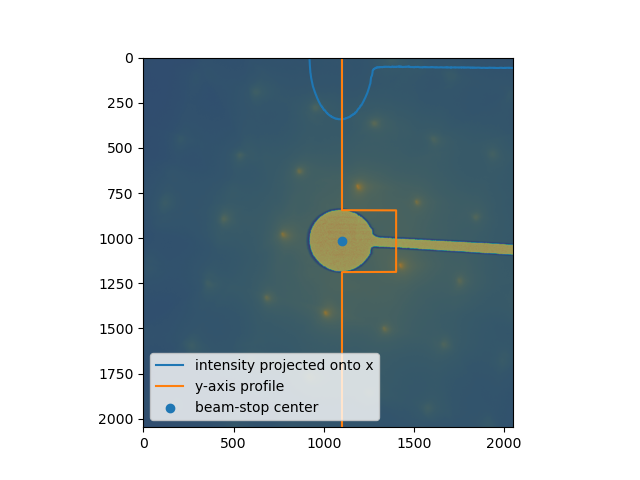

In [4]:
import scipy.ndimage as ndimage

beam_stop = np.zeros(diff_pattern.shape)
beam_stop[diff_pattern < 100] = 1
beam_stop = ndimage.gaussian_filter(beam_stop, sigma=(2, 2), order=0)
beam_stop[beam_stop <= .7] = 0
beam_stop[beam_stop > .7] = 1

# Find maximum of intensity onto x-axis
center_x = np.argmax(beam_stop.sum(axis=0))

# Find center of y-axis line profile at position center_x
center_y = np.average(np.where(beam_stop[:,center_x]>0.7))

print(center_x, center_y)
center = np.array([center_x, center_y])
plt.figure()
plt.imshow(np.log(1+diff_pattern))
plt.imshow(beam_stop, alpha=0.5)
plt.plot(beam_stop.sum(axis=0), label= 'intensity projected onto x')
plt.plot(center_x+beam_stop[:,center_x]*300, np.arange(2048) , label='y-axis profile')

plt.scatter(center[0], center[1], label='beam-stop center')
plt.legend(loc='lower left');

## Determine Bragg Peaks

Peak finding is actually not as simple as it looks

In [5]:
# our blob detectors from the scipy image package
from skimage.feature import blob_dog

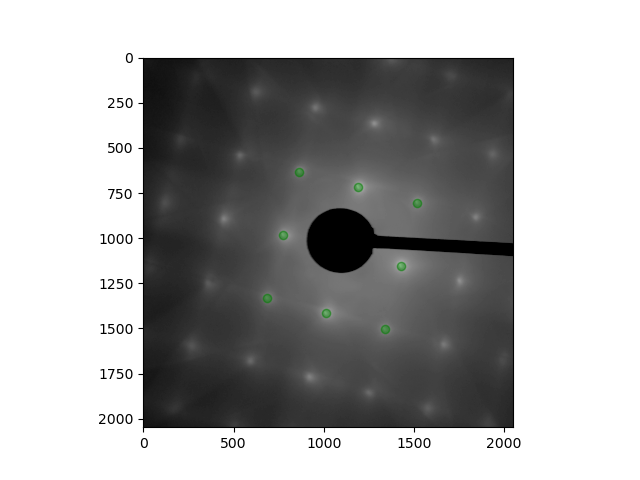

In [6]:

# The beam stop is rather dark
beam_stop = np.argwhere(diff_pattern.T < 50)

# Determine all spots

dif = np.log2(1+diff_pattern).T
dif = dif-dif.min() # blog detector does not like negative values
spots = blob_dog(dif, max_sigma=12, threshold=.8)

Bragg_spots = []

plt.figure()
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)

# We only consider spots not associated with the beam stop (which confuses the blob finder)
for spot in spots:
    if np.min(np.linalg.norm(beam_stop-spot[:2], axis=1))> 50:
        Bragg_spots.append(spot[0:2])
Bragg_spots = np.array(Bragg_spots)
Bragg_spots = Bragg_spots[np.argsort(np.linalg.norm(Bragg_spots[:,:2]-center, axis=1)),:]
plt.scatter(Bragg_spots[:,0], Bragg_spots[:,1], c='green',  alpha = 0.5)




### Refine Center

We use the N innermost reflections and the average of those positions is the new center

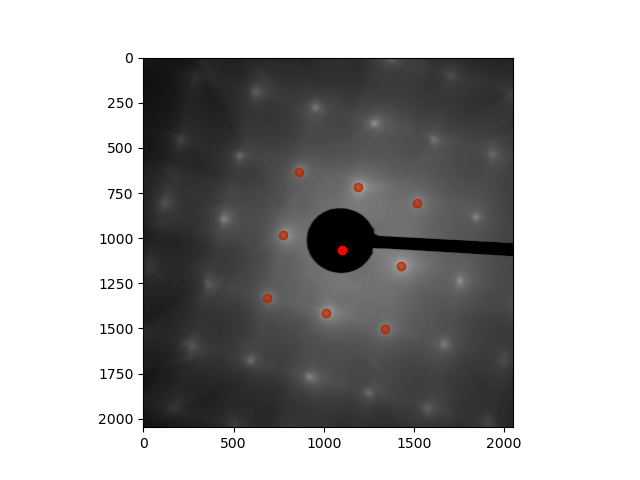

In [7]:
# -------INPUT-----------
number_of_reflections = 8
#------------------------

if number_of_reflections%2 !=0:
    print('Because of inversion symmetry we need an even number')

plt.figure()
plt.imshow(np.log2(1+diff_pattern),cmap="gray", vmin=np.max(np.log2(1+diff_pattern))*0.5)
plt.scatter(Bragg_spots[:,0], Bragg_spots[:,1], c='green',  alpha = 0.5)
plt.scatter(Bragg_spots[:number_of_reflections,0], Bragg_spots[:number_of_reflections,1], c='red',  alpha=0.5)
new_center = np.average(Bragg_spots[:number_of_reflections,:2],axis=0)
plt.scatter(new_center[0], new_center[1], color='red')



### Now we plot with the right scale

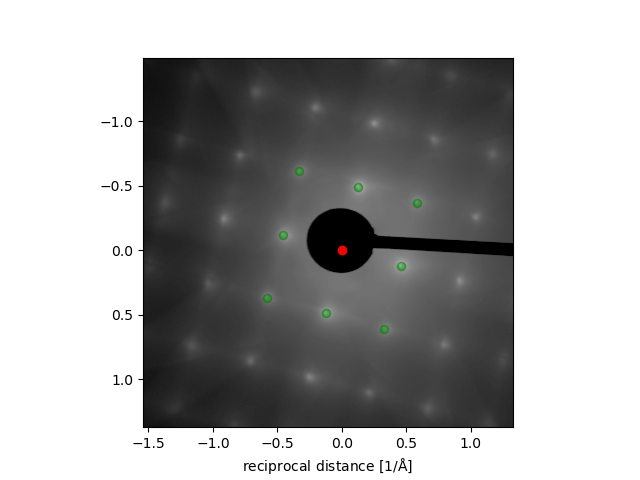

In [8]:
center = new_center
g = gx = gy = ft.get_slope(sidpy_dataset.x.values)
g = gx = gy = scale_300mm*1.09/10
#gx = gy * 1.05

spots_experiment = (Bragg_spots-(center[0],center[1]))*(gx,gy)

fig = plt.figure()
extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

plt.imshow(np.log2(1+diff_pattern), cmap="gray", extent=extent, vmin=np.max(np.log2(1 + diff_pattern)) * 0.5)

plt.scatter(spots_experiment[:,0], spots_experiment[:,1], c='green',  alpha = 0.5,
           label='spots')
plt.xlabel(r'reciprocal distance [1/$\rm \AA$]')
plt.scatter(0,0, color='red')


### The norm of the reflections 
will show us how accurate our center was determined and what give us a first idea on what zone axis we have.
If the center is accurate, we should have always a number of spots with the same distance from center (norm of reciprocal lattice vector) according to symmetry (in [001] direction always 4 reciprocal lattice vectors with the same length)

In [9]:
print('reciprocal distances in 1/Ang')
print(np.sort(np.linalg.norm(spots_experiment,axis=1)))


reciprocal distances in 1/Ang
[0.4702835  0.47095977 0.50442625 0.50459971 0.68907171 0.68966174
 0.6937413  0.69407384]


## Calculate Spot Pattern

see [Plotting of Diffraction Pattern](CH2_07-Plotting_Diffraction_Pattern.ipynb) for details


In [10]:
atoms  = ks.structure_by_name('silicon')
atoms.info['experimental']={}
### Define experimental parameters:
atoms.info['experimental']['acceleration_voltage_V'] = 200.0 *1000.0 #V
atoms.info['experimental']['new_figure'] = False
atoms.info['experimental']['plot FOV'] = 3  # in 1/Ang
atoms.info['experimental']['convergence_angle_mrad'] = 0
atoms.info['experimental']['zone_hkl'] = np.array([0,0,1])  # incident nearest zone axis: defines Laue Zones!!!!
atoms.info['experimental']['mistilt']  = np.array([0,0,0])  # mistilt in degrees
atoms.info['experimental']['Sg_max'] = .04 # 1/Ang  maximum allowed excitation error ; This parameter is related to the thickness
atoms.info['experimental']['hkl_max'] = 15   # Highest evaluated Miller indices

######################################
# Diffraction Simulation of Crystal #
######################################

d = ks.kinematic_scattering(atoms, verbose = True)


The inner potential is 46.5 V
Using an acceleration voltage of 200.0kV
Magnitude of incident wave vector in material: 39.8771 1/Ang and in vacuum: 39.8735 1/Ang
Which is an wave length of 2.508 pm in the material and 2.508 pm in the vacuum
The convergence angle of 0.0mrad = 0.00 1/A
Magnitude of incident wave vector in material: 39.9 1/A which is a wavelength 2.508 pm
Rotation alpha 0.0 degree,  beta 0.0 degree
from zone axis [0 0 1]
Tilting 1 by 0.00  in alpha and 0.00 in beta direction results in :
Next nearest zone axes are:
Center of Ewald sphere  [ 0.          0.         39.87709808]
Of the 29790 tested reciprocal_unit_cell points, 348 have an excitation error less than 0.04 1/nm
Of the 348 possible reflection 56 are allowed.
Laue_circle [0. 0. 0.]
 There are 36 allowed reflections in the zero order Laue Zone
 There are 20 allowed reflections in the first order Laue Zone
 There are 0 allowed reflections in the second order Laue Zone
 There are 0 allowed reflections in the other hi

## Plotting Experimental and Simulated Spot Diffraction Patterns

In [11]:
atoms

Lattice(symbols='Si8', pbc=True, cell=[5.43088, 5.43088, 5.43088])

In [12]:
atoms.info['diffraction'].keys()

dict_keys(['allowed', 'forbidden', 'Laue_circle', 'HOLZ', 'Kikuchi'])

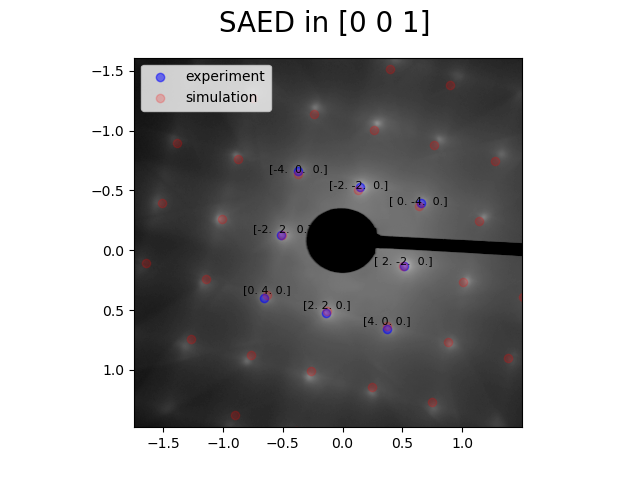

In [30]:
# --------Input------------------
percent_change = 0
# ------------------------------
scale_change = 1. + percent_change/100

tags_simulation = atoms.info['diffraction']
g = gx = gy = ft.get_slope(sidpy_dataset.x.values)
g = gx = gy = scale_300mm*1.12/10 *scale_change
gx = gy * 1.05

extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

angle = 0
angle = np.radians(-59.6)

c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rmat_g= r_mat

spots_experiment = (Bragg_spots-(center[0],center[1]))*(gx,gy)

spots_simulation =  np.dot(tags_simulation['allowed']['g'],r_mat)
spots_ZOLZ = spots_simulation[tags_simulation['allowed']['ZOLZ']]
fig = plt.figure()
fig.suptitle(' SAED in ' + str( atoms.info['experimental']['zone_hkl']), fontsize=20) 
plt.scatter(spots_experiment[:,0], spots_experiment[:,1], c='blue',  alpha = 0.5, label='experiment')
plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='simulation')
plt.imshow(np.log2(1+diff_pattern), cmap="gray", extent=extent, vmin=np.max(np.log2(1 + diff_pattern)) * 0.5)

for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <.8:
        plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
plt.legend()

### What does the above figure convey?

* center is determined accurately
* relative distances are accurately described
* scaling accurately for reference crystal - calibration?
* diffraction pattern is indexed



### What is the accuracy?

Change the scale by 1% and see what happens

So we can determine the lattice parameter better than 1% if we use high scattering angles!

Objective stigmation is critical to resolve angles well.

Illumination stigmation determines size of Bragg spots.


## Conclusion

We need more information for the spot pattern than for the ring pattern.

A comparison between simulation and experiment can be very precise.

In principle, if you have the spots and the approximate center you can let an optimization routine do all the scaling for you (which we will do in the high resolution imaging section).



## Navigation

- <font size = "3">  **Back: [Plotting Diffraction Pattern](CH2_07-Plotting_Diffraction_Pattern.ipynb)** </font>
- <font size = "3">  **Next: [Unit Cell Determination](CH2_09-Unit_Cell.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>


## Appendix 

### Code of Diffraction Simulation of a Crystal

In [ ]:
#######################################
# Diffraction Simulation of a Crystal #
#######################################
ks.kinematic_scattering(atoms, verbose = True)
plt.figure()
plt.scatter(tags_simulation['allowed']['g'][:,0],tags_simulation['allowed']['g'][:,1])
#dynamic_allowed = tags_simulation['forbidden']['g'][tags_simulation['forbidden']['dynamically_activated']]
#plt.scatter(dynamic_allowed[:,0],dynamic_allowed[:,1])


for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <.8:
        plt.text(tags_simulation['allowed']['g'][i,0], tags_simulation['allowed']['g'][i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')

# for i in range(len(dynamic_allowed)):
#    if np.linalg.norm(dynamic_allowed[i]) <8:
#        plt.text(dynamic_allowed[i,0], dynamic_allowed[i,1],str(tags_simulation['forbidden']['hkl'][tags_simulation['forbidden']['dynamically_activated'][i]]),
#                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.gca().set_aspect('equal')
